##*Importing the Required Packages*

In [4]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import Xception, VGG19, ResNet50V2, InceptionV3, MobileNetV2

##*Data Preparation and Pre-processing*

In [5]:
# the image dimensions
img_width, img_height = 299, 299

# batch size for training
batch_size = 32

# the directory paths of the data
train_data_dir = '/content/drive/MyDrive/Dataset/train_data'
validation_data_dir = '/content/drive/MyDrive/Dataset/valid_data'
test_data_dir = '/content/drive/MyDrive/Dataset/test_data'

# performing data augmentation and normalization
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# preprocessing the training data using the training data generator
print(f"TRAINING SET:", end=" ")
train_generator = training_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# loading the images for the validation set
print(f"VALIDATION SET:", end=" ")
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# loading the images for the test set for evaluation
print(f"TEST SET:", end=" ")
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

print("#" * 50)

class_labels = list(train_generator.class_indices.keys())
print(f"CLASS LABELS:")
for i, class_ in enumerate(class_labels):
  print(f"class {i+1} --> {class_}")

TRAINING SET: Found 863 images belonging to 15 classes.
VALIDATION SET: Found 274 images belonging to 15 classes.
TEST SET: Found 283 images belonging to 15 classes.
##################################################
CLASS LABELS:
class 1 --> Africanized Honey Bees (Killer Bees)
class 2 --> Aphids
class 3 --> Armyworms
class 4 --> Brown Marmorated Stink Bugs
class 5 --> Cabbage Loopers
class 6 --> Citrus Canker
class 7 --> Colorado Potato Beetles
class 8 --> Corn Borers
class 9 --> Corn Earworms
class 10 --> Fall Armyworms
class 11 --> Fruit Flies
class 12 --> Spider Mites
class 13 --> Thrips
class 14 --> Tomato Hornworms
class 15 --> Western Corn Rootworms


##*Exploratory Data Analysis*

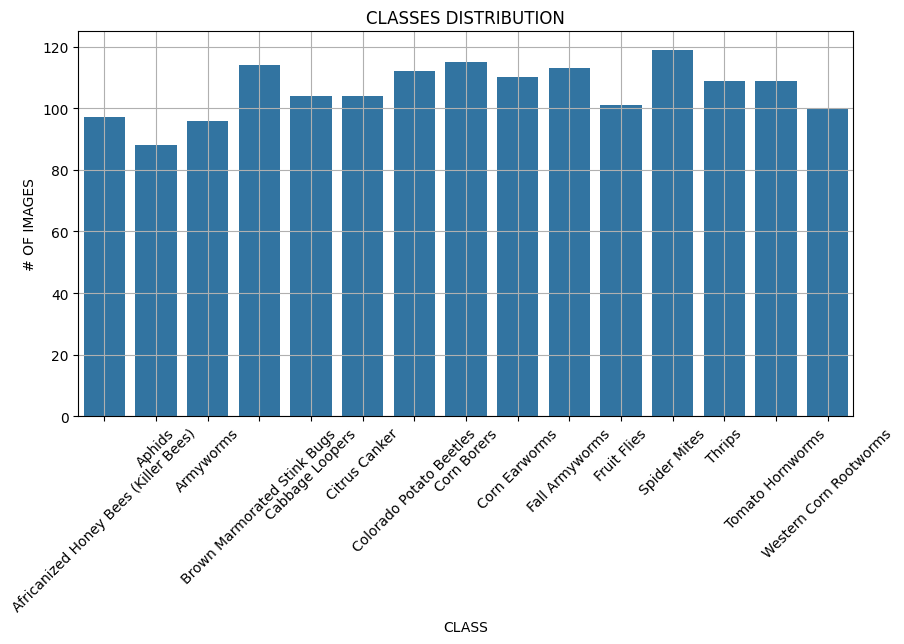

In [ ]:
data_dir = "/content/drive/MyDrive/Dataset/farm_insects"

# class distribution
images_per_class = [len(os.listdir(os.path.join(data_dir, cls))) for cls in class_labels]
plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=images_per_class)
plt.title('CLASSES DISTRIBUTION')
plt.xlabel('CLASS')
plt.ylabel('# OF IMAGES')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

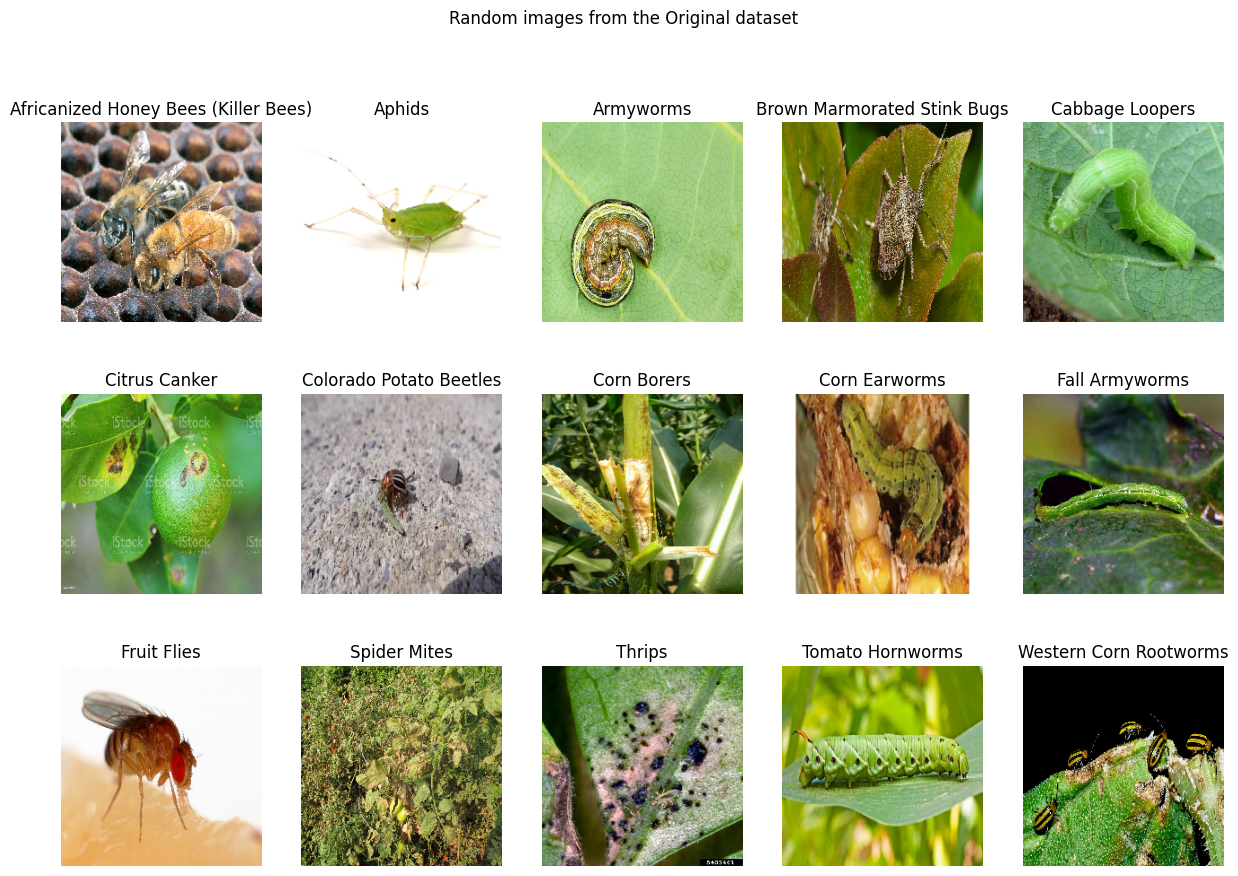

In [ ]:
# some random images from each class from the original dataset
plt.figure(figsize=(15, 10))
for i, cls in enumerate(class_labels):
    image_files = os.listdir(os.path.join(data_dir, cls))
    random_image = np.random.choice(image_files)
    img = image.load_img(os.path.join(data_dir, cls, random_image), target_size=(224, 224))
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle('Random images from the Original dataset')
plt.show()

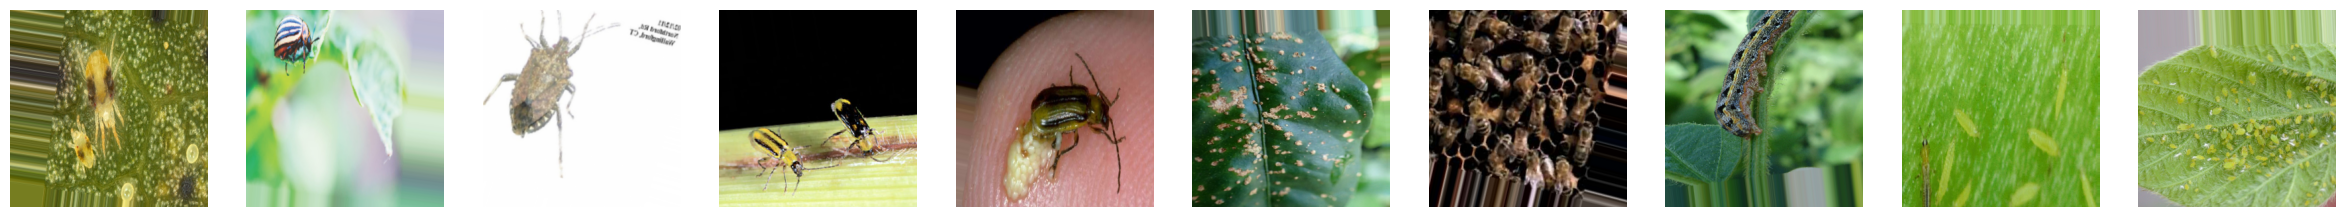

In [ ]:
# some random images from the pre-processed training data
augmented_images, labels = train_generator.next()

# Visualize the augmented images
fig, axes = plt.subplots(1, 10, figsize=(30, 30))
for i in range(10):
    axes[i].imshow(augmented_images[i])
    axes[i].axis('off')
plt.show()

In [6]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))

##*Model Training*

In [7]:
class Model(object):

    def __init__(self, model_name):
      self.model_name = model_name
      self.model_dict = {
        "Xception" : Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
        "VGG19" : VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
        "ResNet50V2" : ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
        "InceptionV3" : InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)),
        "MobileNetV2" : MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
      }
      self.model = self.model_dict[self.model_name]


    def train(self):
      # adding layers on top of the base model
      model = tf.keras.models.Sequential([
                self.model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(256, activation='relu'),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(15, activation='softmax')
      ])

      # compiling the model
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

      # training the model
      print(f"Training the {self.model_name} model")
      history = model.fit(
                train_generator,
                steps_per_epoch=train_generator.samples // batch_size,
                epochs=10,
                validation_data=validation_generator,
                class_weight = class_weights_dict,
                validation_steps=validation_generator.samples // batch_size,
      )

      return model, history

    def evaluate(self, model):
      # evaluating the model's performance on the test data
      evaluation = model.evaluate(test_generator)
      print("Test Accuracy:", evaluation[1])

    def training_plots(self, history):
      # training accuracy vs validation accuracy
      plt.subplot(1, 2, 1)
      plt.plot(history.history['accuracy'])
      plt.plot(history.history['val_accuracy'])
      plt.title(f'{self.model_name} - Model accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend(['train_acc', 'val_acc'], loc='upper left')

      # training loss vs validation loss
      plt.subplot(1, 2, 2)
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title(f'{self.model_name} - Model loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend(['train_acc', 'val_acc'], loc='upper left')

      plt.tight_layout()
      plt.show()

    def evaluation_plots(self, model):
      # Get predictions for the test set
      y_pred = model.predict(test_generator)
      y_pred_classes = np.argmax(y_pred, axis=1)

      # Get true labels for the test set
      y_true = test_generator.classes

      # Compute classification report
      print("Classification Report:")
      print(classification_report(y_true, y_pred_classes))

      # Compute confusion matrix
      cm = confusion_matrix(y_true, y_pred_classes)

      # Plot confusion matrix as heatmap
      plt.figure(figsize=(10, 8))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=class_labels, yticklabels=class_labels)
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.title(f'{self.model_name} - Confusion Matrix')
      plt.show()

##*MobileNetV2*

In [ ]:
model = Model("MobileNetV2")

87910968/87910968 [==============================] - 5s 0us/step


9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
mobv2_model, mobv2_history = model.train()

Training the MobileNetV2 model
Epoch 1/10
26/26 [==============================] - 1070s 40s/step - loss: 2.6593 - accuracy: 0.1239 - val_loss: 2.5362 - val_accuracy: 0.2227
Epoch 2/10
26/26 [==============================] - 45s 2s/step - loss: 2.4019 - accuracy: 0.2768 - val_loss: 2.2722 - val_accuracy: 0.3438
Epoch 3/10
26/26 [==============================] - 46s 2s/step - loss: 1.9584 - accuracy: 0.4332 - val_loss: 1.9650 - val_accuracy: 0.3945
Epoch 4/10
26/26 [==============================] - 41s 2s/step - loss: 1.4292 - accuracy: 0.6065 - val_loss: 1.6572 - val_accuracy: 0.5508
Epoch 5/10
26/26 [==============================] - 44s 2s/step - loss: 1.0267 - accuracy: 0.7232 - val_loss: 1.4643 - val_accuracy: 0.5547
Epoch 6/10
26/26 [==============================] - 45s 2s/step - loss: 0.7429 - accuracy: 0.7894 - val_loss: 1.5500 - val_accuracy: 0.5039
Epoch 7/10
26/26 [==============================] - 44s 2s/step - loss: 0.5745 - accuracy: 0.8387 - val_loss: 1.4058 - val_acc

In [ ]:
model.evaluate(mobv2_model)

9/9 [==============================] - 238s 30s/step - loss: 1.4379 - accuracy: 0.5548
Test Accuracy: 0.554770290851593


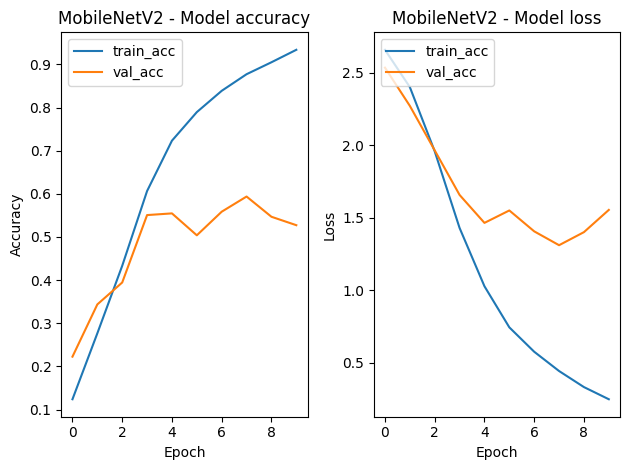

In [ ]:
model.training_plots(mobv2_history)

9/9 [==============================] - 6s 607ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.11      0.05      0.07        19
           2       0.11      0.05      0.07        19
           3       0.00      0.00      0.00        19
           4       0.03      0.05      0.04        19
           5       0.12      0.11      0.11        19
           6       0.00      0.00      0.00        19
           7       0.17      0.05      0.08        19
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00        19
          11       0.10      0.37      0.16        19
          12       0.06      0.05      0.06        19
          13       0.20      0.16      0.18        19
          14       0.17      0.06      0.08        18

    accuracy                           0.06       283
   m

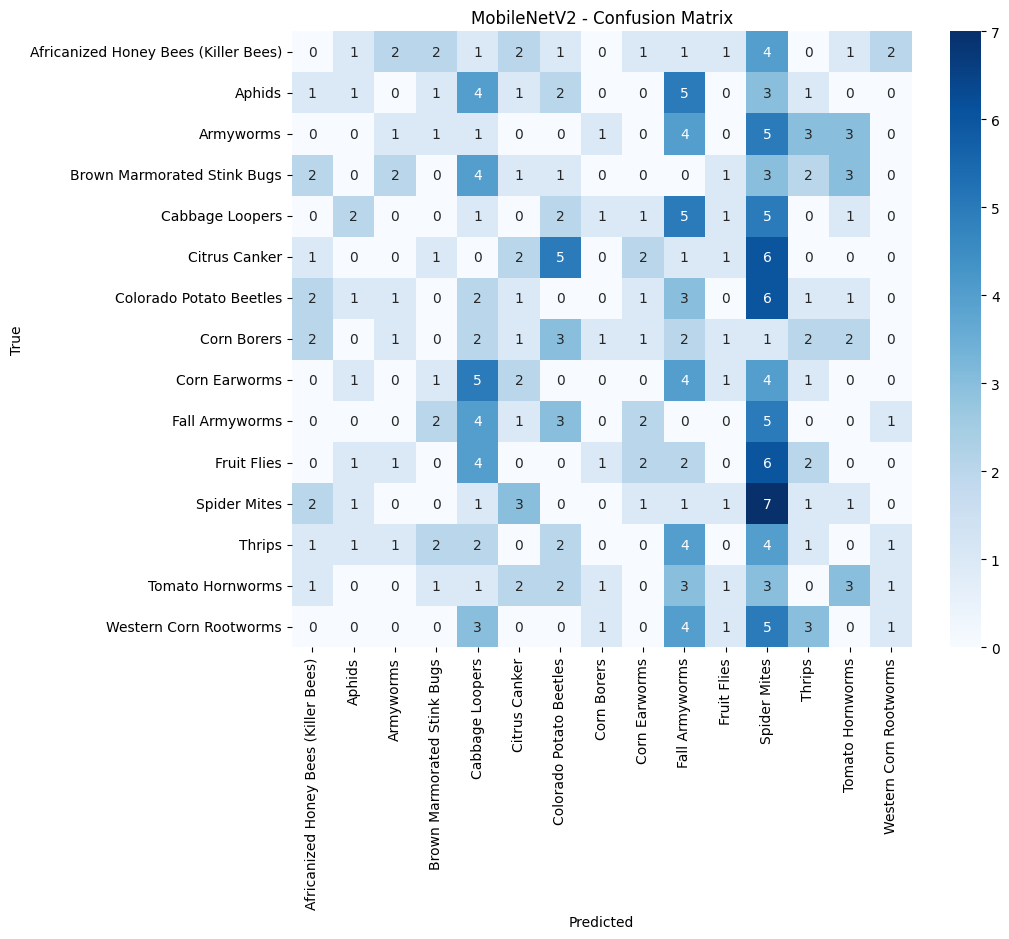

In [ ]:
model.evaluation_plots(mobv2_model)

##*Xception*

In [ ]:
model = Model("Xception")

In [ ]:
xcept_model, xcept_history = model.train()

Training the Xception model
Epoch 1/10
26/26 [==============================] - 95s 2s/step - loss: 2.6307 - accuracy: 0.1372 - val_loss: 2.4452 - val_accuracy: 0.3438
Epoch 2/10
26/26 [==============================] - 48s 2s/step - loss: 2.2258 - accuracy: 0.3791 - val_loss: 1.9482 - val_accuracy: 0.4609
Epoch 3/10
26/26 [==============================] - 48s 2s/step - loss: 1.5828 - accuracy: 0.6306 - val_loss: 1.3513 - val_accuracy: 0.6172
Epoch 4/10
26/26 [==============================] - 52s 2s/step - loss: 0.9935 - accuracy: 0.7714 - val_loss: 1.0243 - val_accuracy: 0.6953
Epoch 5/10
26/26 [==============================] - 50s 2s/step - loss: 0.6084 - accuracy: 0.8460 - val_loss: 1.0532 - val_accuracy: 0.6719
Epoch 6/10
26/26 [==============================] - 53s 2s/step - loss: 0.3778 - accuracy: 0.9061 - val_loss: 0.9225 - val_accuracy: 0.7188
Epoch 7/10
26/26 [==============================] - 48s 2s/step - loss: 0.2718 - accuracy: 0.9302 - val_loss: 0.9128 - val_accuracy:

In [ ]:
model.evaluate(xcept_model)

9/9 [==============================] - 11s 1s/step - loss: 0.8592 - accuracy: 0.7491
Test Accuracy: 0.7491165995597839


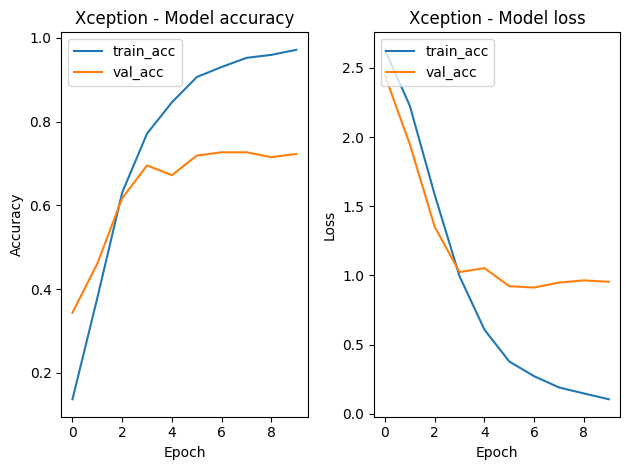

In [ ]:
model.training_plots(xcept_history)

9/9 [==============================] - 14s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.06      0.05      0.06        19
           2       0.19      0.16      0.17        19
           3       0.00      0.00      0.00        19
           4       0.08      0.05      0.06        19
           5       0.09      0.11      0.10        19
           6       0.15      0.16      0.15        19
           7       0.11      0.11      0.11        19
           8       0.00      0.00      0.00        19
           9       0.11      0.11      0.11        18
          10       0.00      0.00      0.00        19
          11       0.10      0.11      0.10        19
          12       0.10      0.11      0.10        19
          13       0.05      0.05      0.05        19
          14       0.00      0.00      0.00        18

    accuracy                           0.07       283
   mac

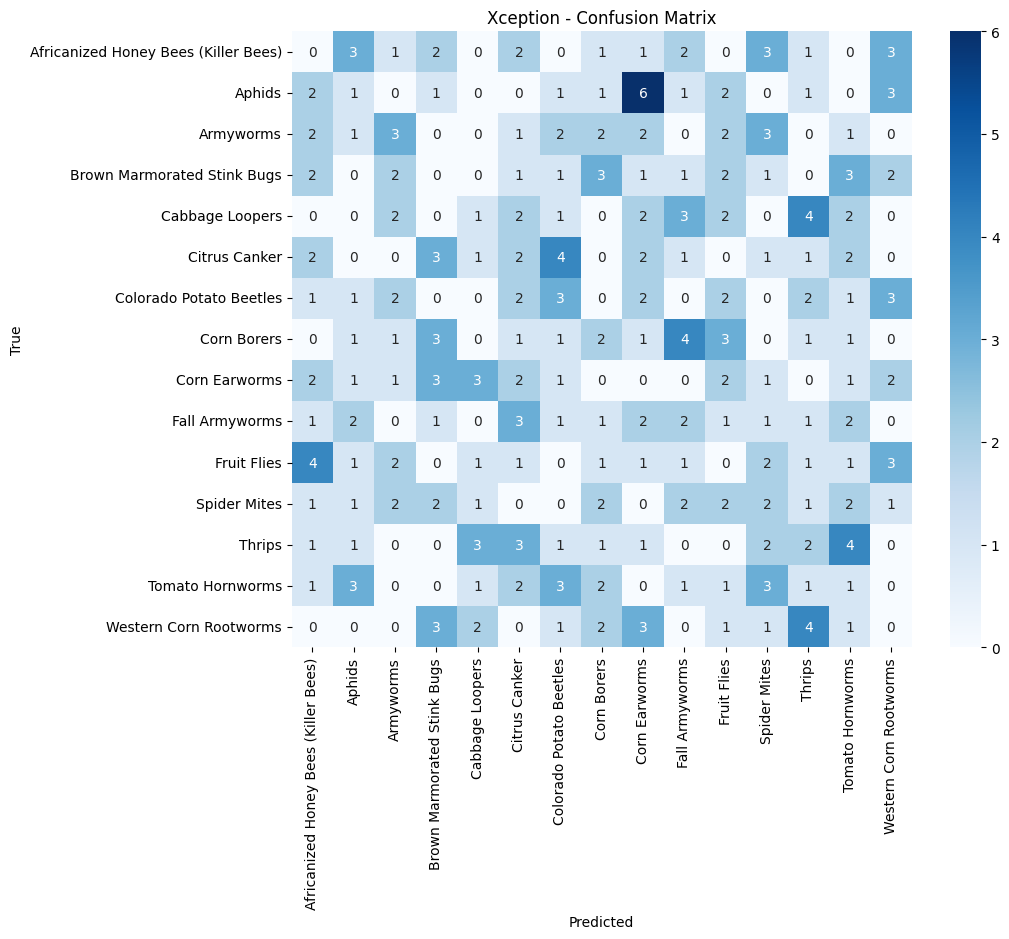

In [ ]:
model.evaluation_plots(xcept_model)

##*VGG19*

In [ ]:
model = Model("VGG19")

In [ ]:
vgg19_model, vgg19_history = model.train()

Training the VGG19 model
Epoch 1/10
26/26 [==============================] - 113s 3s/step - loss: 2.7376 - accuracy: 0.0542 - val_loss: 2.7096 - val_accuracy: 0.1250
Epoch 2/10
26/26 [==============================] - 52s 2s/step - loss: 2.7136 - accuracy: 0.0698 - val_loss: 2.6885 - val_accuracy: 0.0703
Epoch 3/10
26/26 [==============================] - 47s 2s/step - loss: 2.7085 - accuracy: 0.0710 - val_loss: 2.7079 - val_accuracy: 0.0703
Epoch 4/10
26/26 [==============================] - 48s 2s/step - loss: 2.7005 - accuracy: 0.0915 - val_loss: 2.7272 - val_accuracy: 0.0508
Epoch 5/10
26/26 [==============================] - 47s 2s/step - loss: 2.7112 - accuracy: 0.0734 - val_loss: 2.6760 - val_accuracy: 0.1211
Epoch 6/10
26/26 [==============================] - 48s 2s/step - loss: 2.6666 - accuracy: 0.1071 - val_loss: 2.6784 - val_accuracy: 0.1016
Epoch 7/10
26/26 [==============================] - 47s 2s/step - loss: 2.6560 - accuracy: 0.1264 - val_loss: 2.6466 - val_accuracy: 0

In [ ]:
model.evaluate(vgg19_model)

9/9 [==============================] - 15s 2s/step - loss: 2.6128 - accuracy: 0.1661
Test Accuracy: 0.16607773303985596


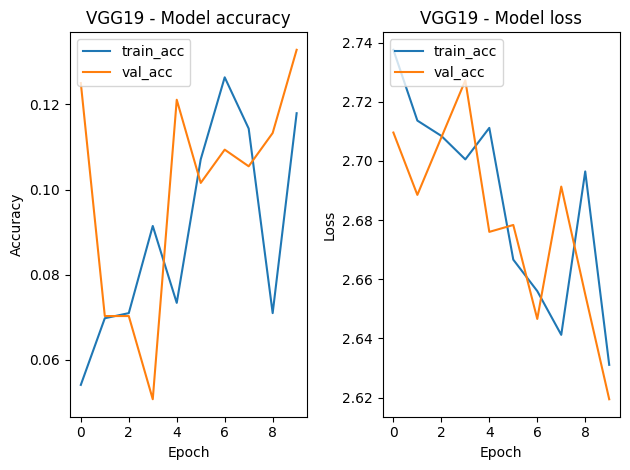

In [ ]:
model.training_plots(vgg19_history)

9/9 [==============================] - 6s 656ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.32      0.16        19
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        19
           7       0.11      0.11      0.11        19
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00        18
          10       0.10      0.37      0.16        19
          11       0.07      0.16      0.10        19
          12       0.00      0.00      0.00        19
          13       0.12      0.53      0.20        19
          14       0.00      0.00      0.00        18

    accuracy                           0.10       283
   m

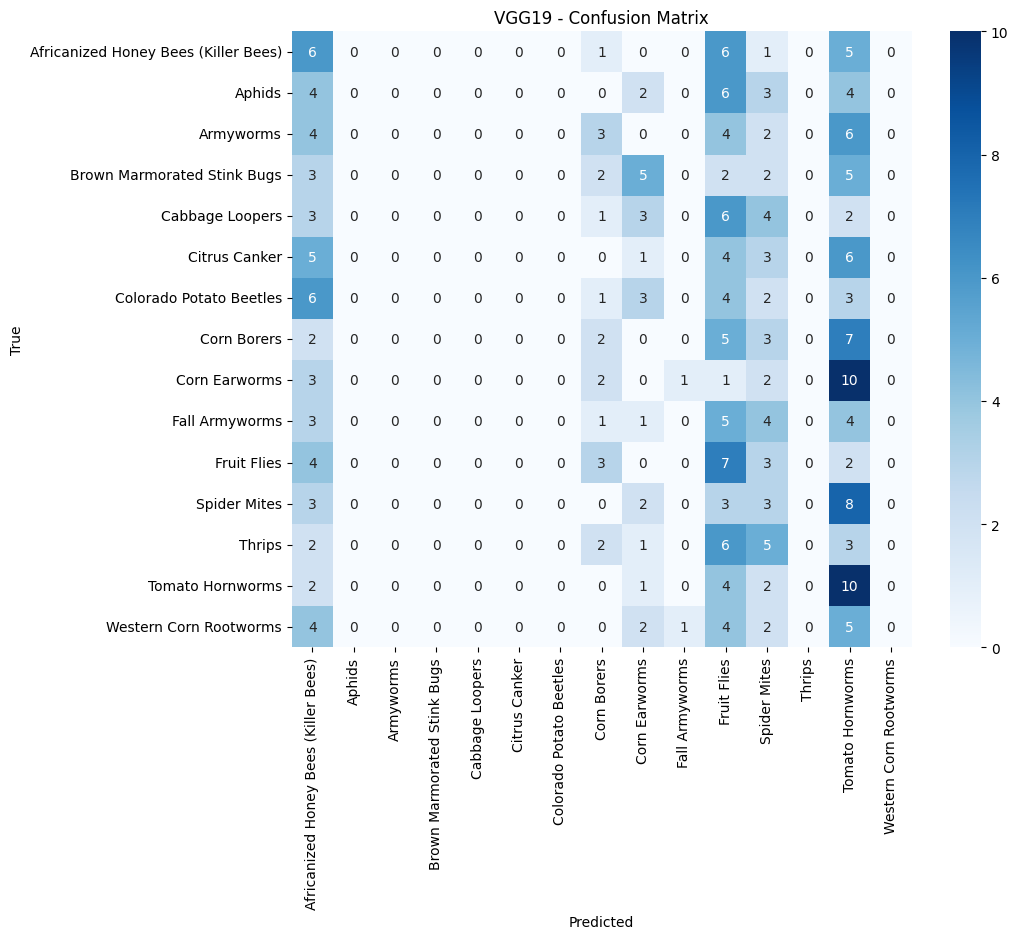

In [ ]:
model.evaluation_plots(vgg19_model)

##*InceptionV3*

In [ ]:
model = Model("InceptionV3")

In [ ]:
incept_model, incept_history = model.train()

Training the InceptionV3 model
Epoch 1/10
26/26 [==============================] - 99s 2s/step - loss: 2.5887 - accuracy: 0.1709 - val_loss: 2.2731 - val_accuracy: 0.3750
Epoch 2/10
26/26 [==============================] - 42s 2s/step - loss: 1.9271 - accuracy: 0.5030 - val_loss: 1.5424 - val_accuracy: 0.5273
Epoch 3/10
26/26 [==============================] - 46s 2s/step - loss: 1.1487 - accuracy: 0.7196 - val_loss: 1.2331 - val_accuracy: 0.6328
Epoch 4/10
26/26 [==============================] - 43s 2s/step - loss: 0.6343 - accuracy: 0.8291 - val_loss: 1.1856 - val_accuracy: 0.6484
Epoch 5/10
26/26 [==============================] - 44s 2s/step - loss: 0.3984 - accuracy: 0.8905 - val_loss: 1.1835 - val_accuracy: 0.6797
Epoch 6/10
26/26 [==============================] - 43s 2s/step - loss: 0.2767 - accuracy: 0.9290 - val_loss: 1.1740 - val_accuracy: 0.6719
Epoch 7/10
26/26 [==============================] - 42s 2s/step - loss: 0.1987 - accuracy: 0.9398 - val_loss: 1.1960 - val_accura

In [ ]:
model.evaluate(incept_model)

9/9 [==============================] - 10s 1s/step - loss: 0.9854 - accuracy: 0.7562
Test Accuracy: 0.7561837434768677


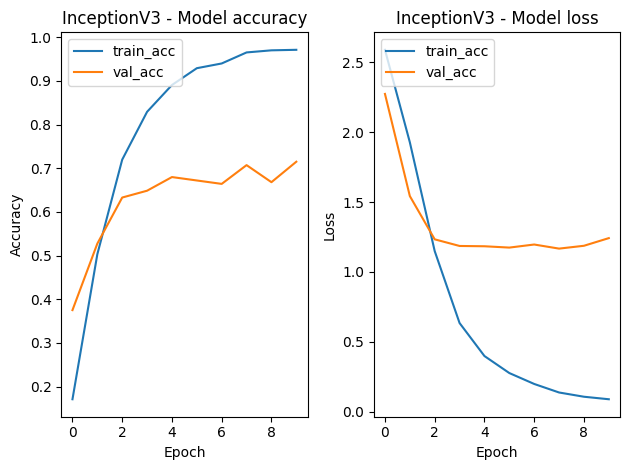

In [ ]:
model.training_plots(incept_history)

9/9 [==============================] - 8s 615ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.11      0.10        19
           1       0.00      0.00      0.00        19
           2       0.04      0.05      0.05        19
           3       0.00      0.00      0.00        19
           4       0.06      0.05      0.05        19
           5       0.05      0.05      0.05        19
           6       0.17      0.21      0.19        19
           7       0.12      0.05      0.07        19
           8       0.06      0.11      0.08        19
           9       0.08      0.06      0.07        18
          10       0.12      0.11      0.11        19
          11       0.05      0.05      0.05        19
          12       0.07      0.05      0.06        19
          13       0.16      0.16      0.16        19
          14       0.07      0.06      0.06        18

    accuracy                           0.07       283
   m

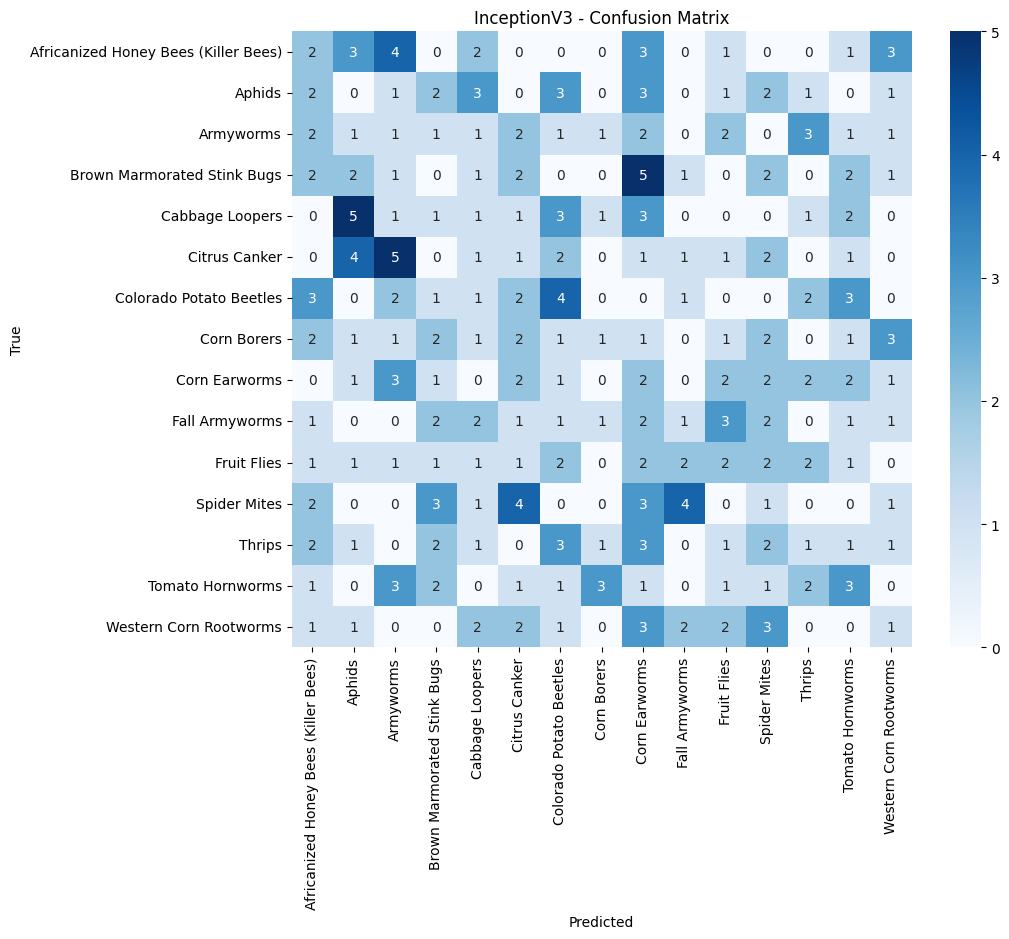

In [ ]:
model.evaluation_plots(incept_model)

##*ResNet50V2*

In [8]:
model = Model("ResNet50V2")

87910968/87910968 [==============================] - 5s 0us/step


9406464/9406464 [==============================] - 2s 0us/step


In [9]:
resnet_model, resnet_history = model.train()

Training the ResNet50V2 model
Epoch 1/10
26/26 [==============================] - 1074s 40s/step - loss: 2.6383 - accuracy: 0.1372 - val_loss: 2.3691 - val_accuracy: 0.2578
Epoch 2/10
26/26 [==============================] - 41s 2s/step - loss: 2.0979 - accuracy: 0.3875 - val_loss: 1.5884 - val_accuracy: 0.5000
Epoch 3/10
26/26 [==============================] - 42s 2s/step - loss: 1.4576 - accuracy: 0.6017 - val_loss: 1.4105 - val_accuracy: 0.6328
Epoch 4/10
26/26 [==============================] - 42s 2s/step - loss: 0.9049 - accuracy: 0.7533 - val_loss: 1.6232 - val_accuracy: 0.6641
Epoch 5/10
26/26 [==============================] - 43s 2s/step - loss: 0.5787 - accuracy: 0.8448 - val_loss: 1.7412 - val_accuracy: 0.6797
Epoch 6/10
26/26 [==============================] - 42s 2s/step - loss: 0.3955 - accuracy: 0.8821 - val_loss: 1.6299 - val_accuracy: 0.6719
Epoch 7/10
26/26 [==============================] - 42s 2s/step - loss: 0.2976 - accuracy: 0.9146 - val_loss: 1.4058 - val_accu

In [10]:
model.evaluate(resnet_model)

9/9 [==============================] - 253s 31s/step - loss: 1.3989 - accuracy: 0.6784
Test Accuracy: 0.6784452199935913


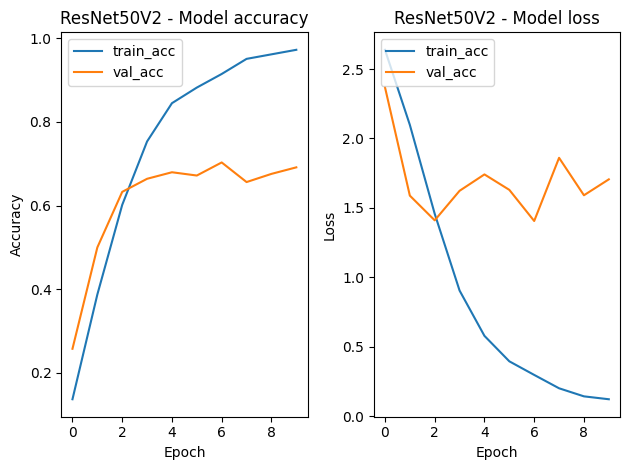

In [11]:
model.training_plots(resnet_history)

9/9 [==============================] - 6s 616ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.11      0.10        19
           1       0.05      0.05      0.05        19
           2       0.03      0.05      0.04        19
           3       0.05      0.05      0.05        19
           4       0.06      0.05      0.06        19
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        19
           7       0.06      0.05      0.06        19
           8       0.06      0.05      0.06        19
           9       0.08      0.06      0.07        18
          10       0.00      0.00      0.00        19
          11       0.00      0.00      0.00        19
          12       0.10      0.05      0.07        19
          13       0.08      0.11      0.09        19
          14       0.15      0.17      0.16        18

    accuracy                           0.05       283
   m

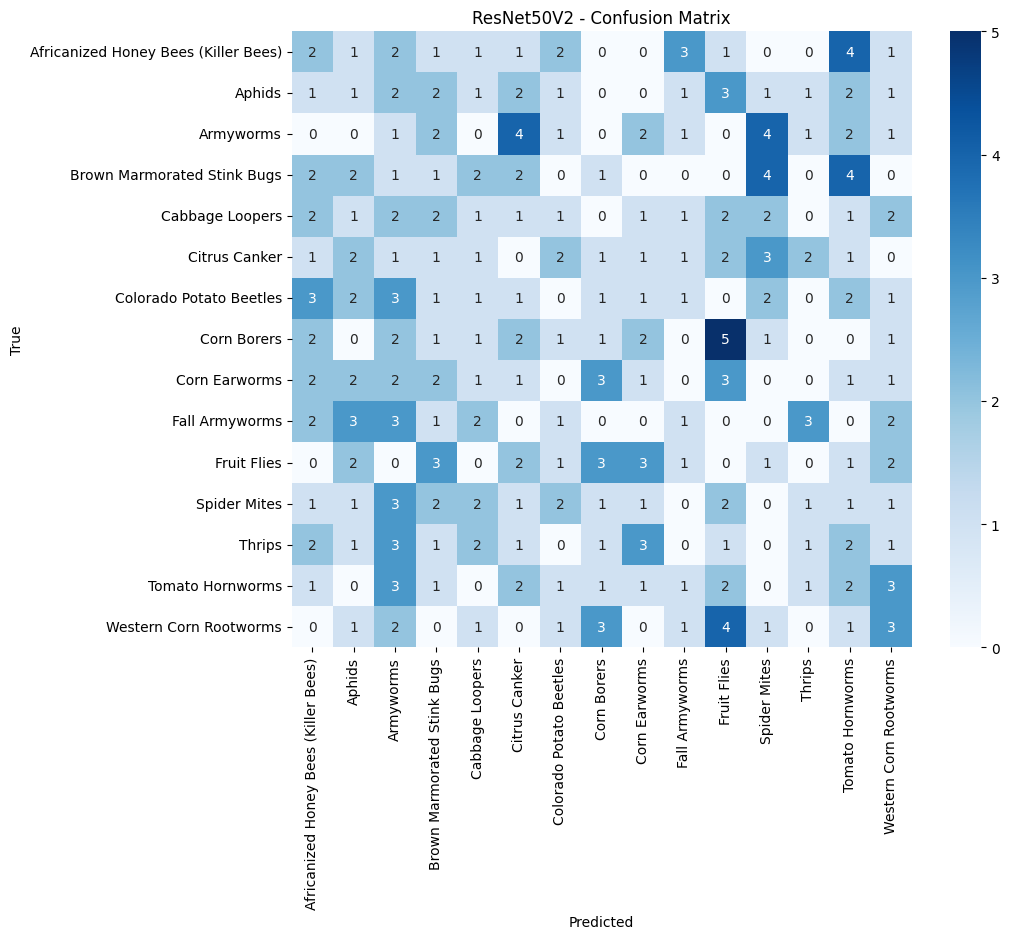

In [12]:
model.evaluation_plots(resnet_model)

In [33]:
def preprocess_image(img_array):
    # Convert pixel values to the range [0, 1]
    img_array /= 255.0

    return img_array

In [50]:
# Load and preprocess the image
img_path = '/content/drive/MyDrive/Dataset/Image_20.jpg'
img = image.load_img(img_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = preprocess_image(img_array)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch

# Make prediction
prediction = resnet_model.predict(img_array)

1/1 [==============================] - 0s 22ms/step


In [51]:
prediction

array([[4.3625578e-19, 1.5246856e-13, 2.1114161e-14, 7.9255422e-16,
        3.9762217e-13, 2.3175805e-13, 2.2727758e-17, 3.1140624e-17,
        8.2628825e-17, 1.3295045e-13, 2.3447845e-12, 1.0000000e+00,
        6.5941215e-12, 4.0893758e-18, 1.7711533e-18]], dtype=float32)

In [52]:
# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)

# Get the corresponding class label
predicted_class_label = class_labels[predicted_class_index]

print("Predicted Class Label:", predicted_class_label)

Predicted Class Label: Spider Mites


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
